<a href="https://colab.research.google.com/github/pdh21/OCF_PVmapper/blob/main/Example_DeepNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/pdh21/OCF_PVmapper/blob/main/Example_DeepNet.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

![](https://avatars.githubusercontent.com/u/48357542?s=200&v=4)

## PV mapping Example:
[Peter Hurley](http://pdh21.github.io/) 

In this notebook, we will read in the cutouts and convert them to TensorFlow record format

In [28]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [30]:
cd gdrive/MyDrive/PVmapping/cutouts

[Errno 2] No such file or directory: 'gdrive/MyDrive/PVmapping/cutouts'
/content/gdrive/MyDrive/PVmapping/cutouts


In [31]:
pip install tensorflow-io

In [33]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


In [35]:
FILE_PATTERN='./*aerial*.tif'
OUTPUT = '../cutouts_tfrecords/'  # prefix for output file names
TARGET_SIZE = [75,75]


filenames_dataset = tf.data.Dataset.list_files('./*aerial*.tif')

In [36]:
SHARDS = 16


In [37]:
nb_images = len(tf.io.gfile.glob(FILE_PATTERN))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_tif_and_label(filename):
  bits_aerial = tf.io.read_file(filename)
  bits_binary = tf.io.read_file(tf.strings.regex_replace(filename, "aerial", "binary"))
  image_aerial = tfio.experimental.image.decode_tiff(bits_aerial)[:,:,0:3]
  image_binary = tfio.experimental.image.decode_tiff(bits_binary)[:,:,0:1]


  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='_')
  num = label.values[2]
  pos_neg=  label.values[0]
  #im_type=label_3.values[1]
  return image_aerial,image_binary,pos_neg,num

Pattern matches 3999 images which will be rewritten as 16 .tfrec files containing 250 images each.


In [38]:
dataset1 = filenames_dataset.map(decode_tif_and_label)

In [40]:
def resize_and_crop_image(image_aerial,image_binary, label,num):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image_aerial)[0]
  h = tf.shape(image_aerial)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image_aerial = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image_aerial, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image_aerial, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image_aerial)[0]
  nh = tf.shape(image_aerial)[1]

  image_binary = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image_binary, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image_binary, [w*th/h, h*th/h])  # if false
                  )
  image_aerial = tf.image.crop_to_bounding_box(image_aerial, (nw - tw) // 2, (nh - th) // 2, tw, th)
  image_binary = tf.image.crop_to_bounding_box(image_binary, (nw - tw) // 2, (nh - th) // 2, tw, th)

  return image_aerial,image_binary, label,num
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

In [ ]:
def recompress_image(image_aerial,image_binary,label,num):
  height = tf.shape(image_aerial)[0]
  width = tf.shape(image_aerial)[1]
  image_aerial = tf.cast(image_aerial, tf.uint8)
  image_binary = tf.cast(image_binary, tf.uint8)

  image_aerial = tf.image.encode_jpeg(image_aerial, optimize_size=True, chroma_downsampling=False)
  image_binary = tf.image.encode_jpeg(image_binary, optimize_size=True, chroma_downsampling=False)


  return image_aerial,image_binary,label,num,width,height

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

## Write dataset to TFRecord *files*

In [ ]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, image_aerial_bytes, image_binary_bytes, label,num,height,width):  

  feature = {
      "image_aerial": _bytestring_feature([image_aerial_bytes]), # one image in the list
      "image_binary": _bytestring_feature([image_binary_bytes]),       
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "num":         _bytestring_feature([num]),          # fixed length (1) list of strings, the text label

      "size":          _int_feature([height, width]),         # fixed length (2) list of ints

  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image_aerial, image_binary, label, num,height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image_aerial.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image_aerial.numpy()[i], # re-compressed image: already a byte string
                            image_binary.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            num.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])

      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ../cutouts_tfrecords/00-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/01-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/02-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/03-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/04-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/05-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/06-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/07-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/08-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/09-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/10-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/11-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/12-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecords/13-250.tfrec containing 250 records
Wrote file ../cutouts_tfrecord

## Read  from TFRecord Dataset


In [ ]:
def read_tfrecord(example):
    features = {
        "image_aerial": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "image_binary": tf.io.FixedLenFeature([], tf.string),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "num":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers

    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image_aerial = tf.image.decode_jpeg(example['image_aerial'], channels=3)
    image_aerial = tf.reshape(image_aerial, [*TARGET_SIZE, 3])

    image_binary = tf.image.decode_jpeg(example['image_binary'], channels=1)
    image_binary = tf.reshape(image_binary, [*TARGET_SIZE, 1])
    
    
    label  = example['label']
    num = example['num']
    height = example['size'][0]
    width  = example['size'][1]
    return image_aerial,image_binary, label, num, height, width
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

In [ ]:
display_dataset = dataset4.map(lambda image_aerial,image_binary,label,num, height, width: (image_aerial,image_binary,label,num))

In [85]:
def display_9_images_from_dataset(dataset):
  fig,axes=plt.subplots(9,2,figsize=(10,30))
  for i, (image_aerial,image_binary,label,num) in enumerate(dataset):
    axes[i,0].imshow(image_aerial.numpy().astype(np.uint8))
    axes[i,1].imshow(image_binary.numpy().astype(np.uint8)[:,:,0])
    axes[i,0].set_title(label.numpy().decode("utf-8")+' '+num, fontsize=16)
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

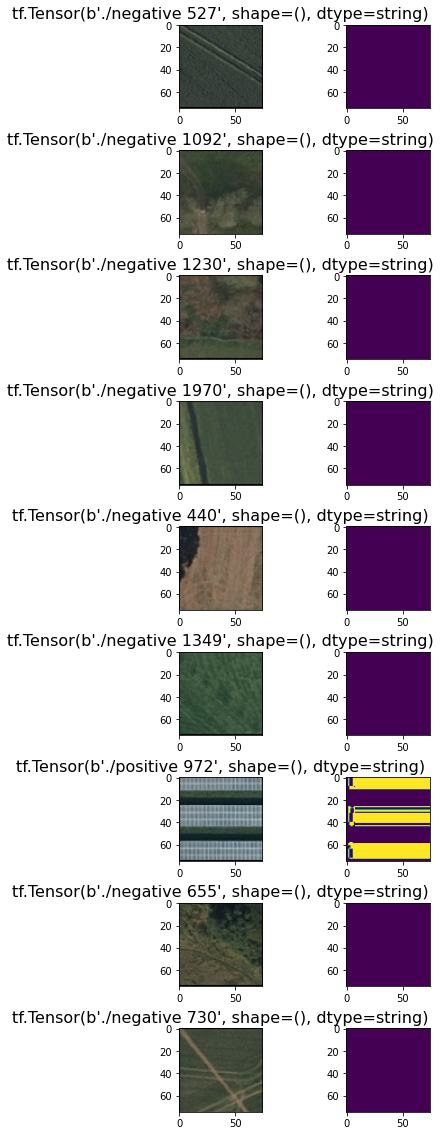

In [ ]:
display_9_images_from_dataset(display_dataset)

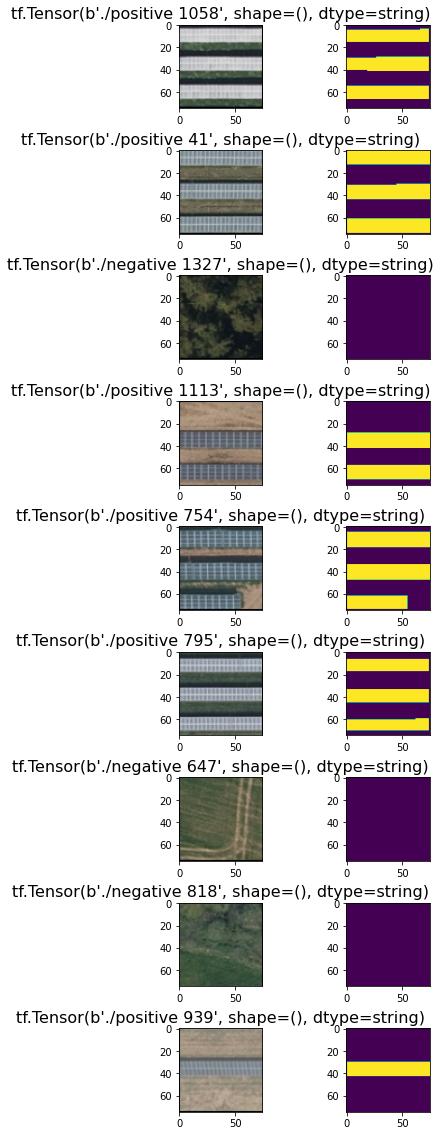

In [ ]:
display_9_images_from_dataset(dataset2)

In [103]:
def recompress_image_2(image_aerial,image_binary,label,num):
  height = tf.shape(image_aerial)[0]
  width = tf.shape(image_aerial)[1]
  image_aerial = tf.cast(image_aerial, tf.uint8)
  image_binary = tf.cast(image_binary, tf.uint8)

  image_aerial =  tf.image.encode_png(image_aerial)
  image_binary = tf.image.encode_png(image_binary,compression=0)


  return image_aerial,image_binary,label,num,width,height

dataset3 = dataset2.map(recompress_image_2, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))

def to_tfrecord_2(tfrec_filewriter, image_aerial_bytes, image_binary_bytes, label,num,height,width):  

  feature = {
      "image_aerial": _bytestring_feature([image_aerial_bytes]), # one image in the list
      "image_binary": _bytestring_feature([image_binary_bytes]),       
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "num":         _bytestring_feature([num]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints

  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image_aerial, image_binary, label, num,height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image_aerial.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord_2(out_file,
                            image_aerial.numpy()[i], # re-compressed image: already a byte string
                            image_binary.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            num.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])

      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ../cutouts_tfrecords/00-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/01-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/02-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/03-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/04-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/05-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/06-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/07-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/08-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/09-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/10-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/11-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/12-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/13-3.tfrec containing 3 records
Wrote file ../cutouts_tfrecords/14-3.tfrec containing 3 records
Wrote file ../cutouts_

In [111]:
def read_tfrecord_2(example):
    features = {
        "image_aerial": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "image_binary": tf.io.FixedLenFeature([], tf.string),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "num":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers

    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    
    label  = example['label']
    num = example['num']
    height = example['size'][0]
    width  = example['size'][1]

    image_aerial = tf.image.decode_png(example['image_aerial'],channels=3)
    image_aerial = tf.reshape(image_aerial, [*TARGET_SIZE, 3])
    image_binary = tf.image.decode_png(example['image_binary'],channels=1)
    image_binary = tf.reshape(image_binary, [*TARGET_SIZE, 1])
    
    

    return image_aerial,image_binary, label, num, height, width
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord_2, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(200)

In [124]:
dataset4 = dataset4.shuffle(33)
display_dataset = dataset4.map(lambda image_aerial,image_binary,label,num, height, width: (image_aerial,image_binary,label,num))

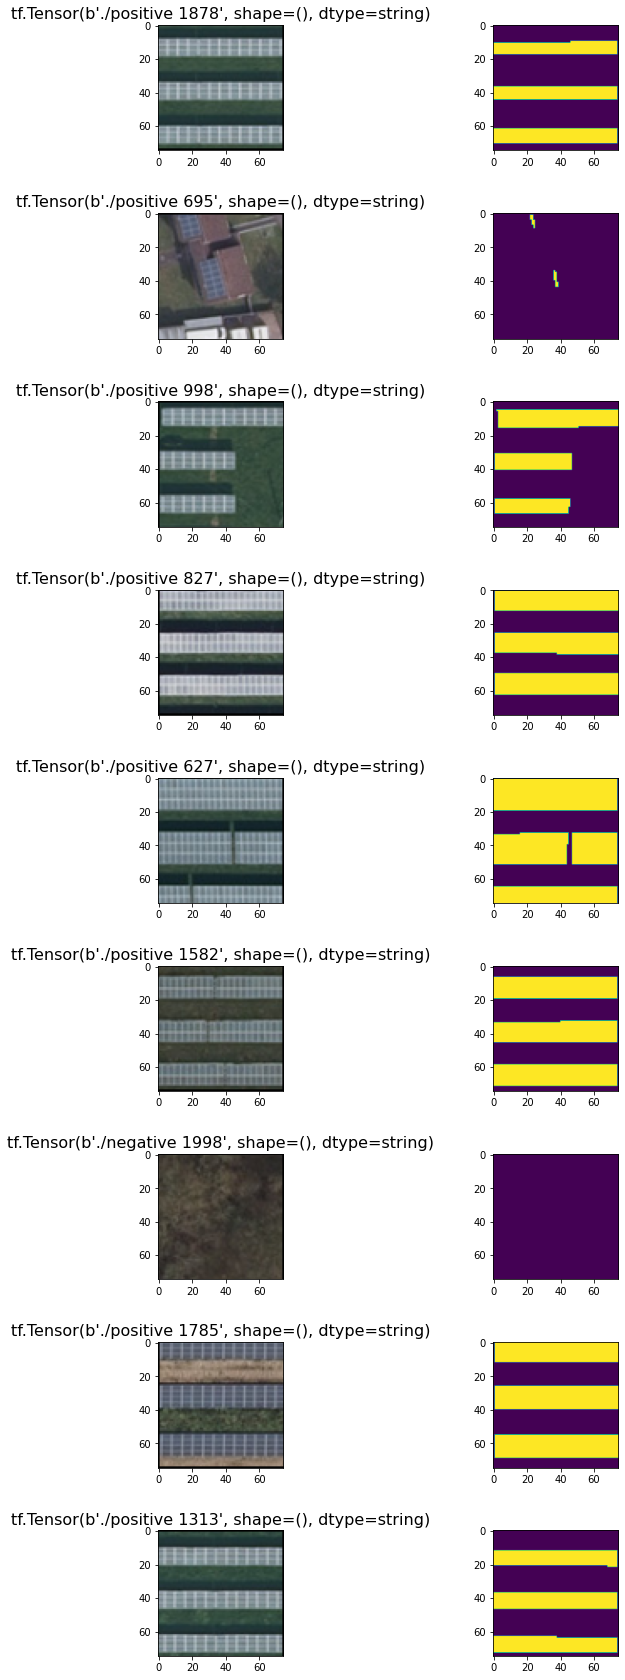

In [125]:
display_9_images_from_dataset(display_dataset)